In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import math


In [2]:
# Dataset paths
train_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\train'
valid_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\valid'
test_dir = r'C:\Users\Yashuu\Downloads\WFD(MAIN)\Classification\test'


In [3]:
# Data Augmentation (Optimized)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Data Generators
batch_size = 16
target_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False)


Found 1140 images belonging to 2 classes.
Found 380 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [5]:
# Learning Rate Scheduler (Cosine Annealing)
def cosine_annealing(epoch):
    initial_lr = 0.0001
    lr = initial_lr * (math.cos(epoch / 15 * math.pi) + 1) / 2
    return lr
lr_scheduler = LearningRateScheduler(cosine_annealing)


In [6]:
# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [7]:
# Load Pretrained VGG16 (Feature Extractor)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:10]:
    layer.trainable = False

In [8]:
# Model Architecture
model = Sequential([
    base_model,
    SpatialDropout2D(0.3),
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [9]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
# Train Model
history = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    epochs=5, 
    callbacks=[lr_reduce, early_stop, checkpoint, lr_scheduler]
)


Epoch 1/5
72/72 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.9930
Epoch 1: val_loss did not improve from 0.67817
72/72 [==============================] - 546s 8s/step - loss: 0.4735 - accuracy: 0.9930 - val_loss: 1.0114 - val_accuracy: 0.8105 - lr: 1.0000e-04
Epoch 2/5
72/72 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.9947
Epoch 2: val_loss did not improve from 0.67817
72/72 [==============================] - 509s 7s/step - loss: 0.4699 - accuracy: 0.9947 - val_loss: 0.6834 - val_accuracy: 0.9000 - lr: 9.8907e-05
Epoch 3/5
72/72 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.9982
Epoch 3: val_loss improved from 0.67817 to 0.51362, saving model to best_model.h5


C:\Users\Yashuu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 509s 7s/step - loss: 0.4436 - accuracy: 0.9982 - val_loss: 0.5136 - val_accuracy: 0.9447 - lr: 9.5677e-05
Epoch 4/5
72/72 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.9570
Epoch 4: val_loss did not improve from 0.51362
72/72 [==============================] - 532s 7s/step - loss: 0.5254 - accuracy: 0.9570 - val_loss: 2.3848 - val_accuracy: 0.7421 - lr: 9.0451e-05
Epoch 5/5
72/72 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.9921
Epoch 5: val_loss improved from 0.51362 to 0.46765, saving model to best_model.h5
72/72 [==============================] - 507s 7s/step - loss: 0.4431 - accuracy: 0.9921 - val_loss: 0.4676 - val_accuracy: 0.9895 - lr: 8.3457e-05


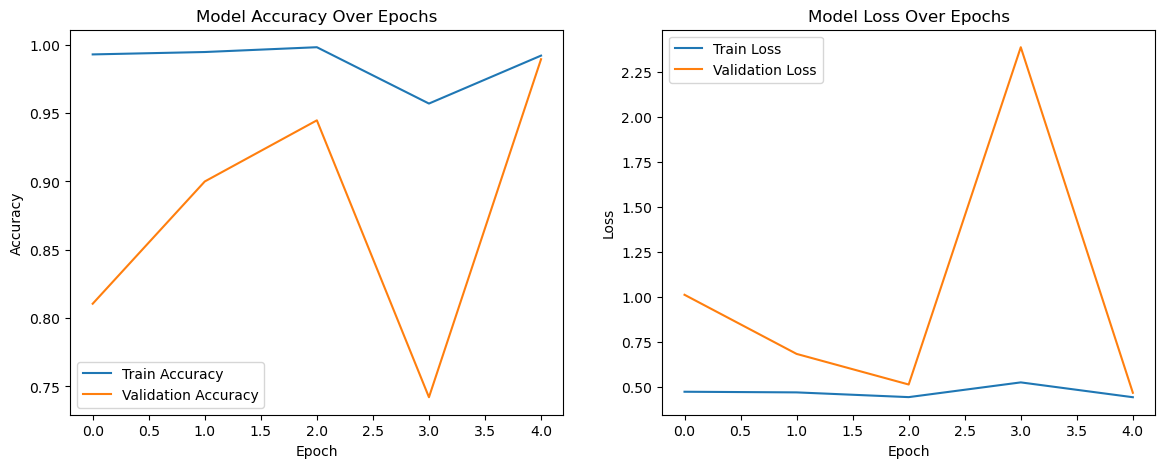

In [36]:
# Plot Training Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [33]:
# Evaluate Model
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator).flatten()
y_pred = (y_pred_proba > 0.7).astype('int32')


24/24 [==============================] - 80s 3s/step


In [34]:
# Final Test Accuracy
final_test_acc = np.mean(y_true == y_pred)
print(f'Final Test Accuracy: {final_test_acc * 100:.2f}%')

Final Test Accuracy: 98.42%


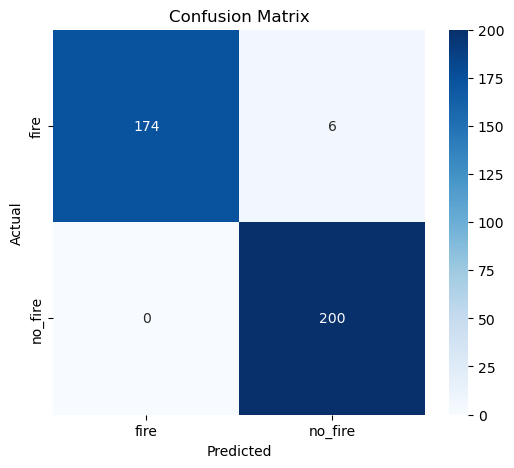

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Precision, Recall, F1-Score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")




In [ ]:
# Precision-Recall Curve (Plot vs Threshold)
from sklearn.metrics import precision_recall_curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_pred_proba)
plt.figure(figsize=(7, 5))
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve (Threshold vs Precision/Recall)')
plt.legend()
plt.grid(True)
plt.show()